In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Check for gpu accelleration
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
## Adjust gpu memory
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Default GPU Device: /device:GPU:0


In [3]:
## Read brain images from directory
import glob
from PIL import Image

fileList = glob.glob("images/*.nii.png")
X_train = np.array([np.array(Image.open(fname)) for fname in fileList])

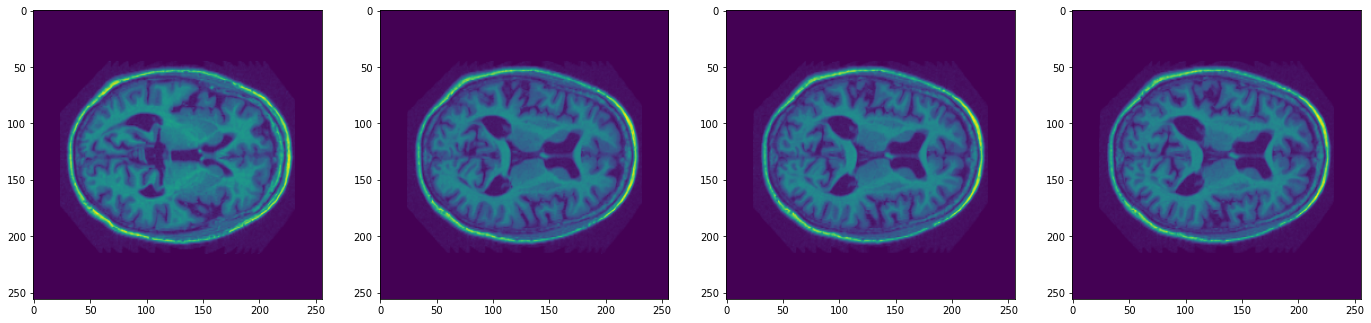

(10208, 256, 256)

In [4]:
## Show sample images
fig = plt.figure(figsize=(30,10))
nplot = 5
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()
X_train.shape

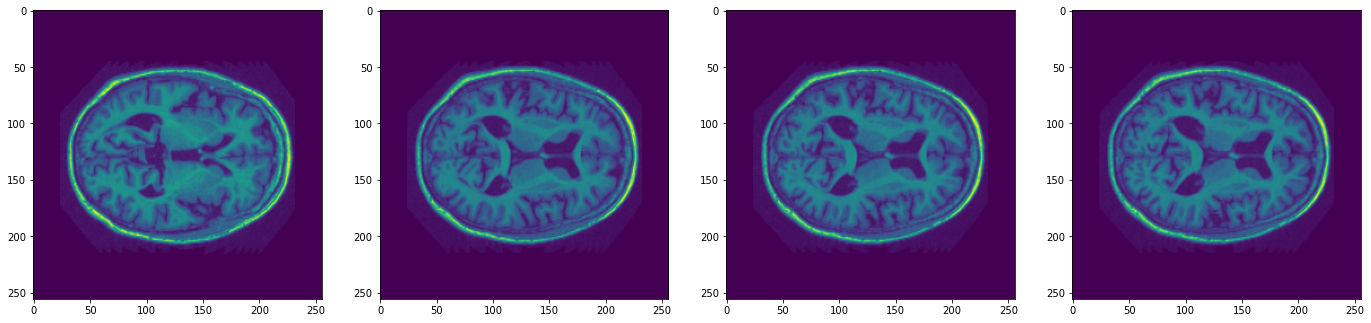

(10208, 256, 256)

In [5]:
## Adjust and scale values to 0-1
X_train = X_train/255.0
fig = plt.figure(figsize=(30,10))
nplot = 5
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()
X_train.shape

In [6]:
## Design network
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose,Conv1D
from tensorflow.keras.models import Sequential

In [7]:
## For testing consistency the same random seed is used
np.random.seed(7)
tf.random.set_seed(7)
noise_size = 100

In [17]:
## Generator design
generator = Sequential()
generator.add(Dense(100, input_shape=[noise_size]))
generator.add(Dense(256*4*256*4, activation = 'relu'))
generator.add(Reshape([256*4,  256*4]))
generator.add(BatchNormalization())
generator.add(Conv1D(512, kernel_size=5, strides=1, padding="same", activation="sigmoid"))
generator.add(BatchNormalization())
generator.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="sigmoid"))



In [9]:
## Discriminator design
discriminator = Sequential()
discriminator.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[256,256]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
generator.add(Dense(100, activation = 'relu'))
discriminator.add(Dense(1, activation="sigmoid"))



In [10]:
# Build
GAN = Sequential([generator, discriminator])
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [11]:
## Generator summary
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1048576)           105906176 
_________________________________________________________________
reshape (Reshape)            (None, 1024, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024)        4096      
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 512)          1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512)          2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 256)          3

In [12]:
## Discriminator summary
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1048576)           105906176 
_________________________________________________________________
reshape (Reshape)            (None, 1024, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024)        4096      
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 512)          1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512)          2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 256)          3

In [13]:
## Learning parameters
epochs = 20
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=500)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [14]:
# Learning Loop
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
       
        
        # Discriminator Training      
        
        noise = tf.random.normal(shape=[batch_size, noise_size])
        gen_images = generator(noise)
        
        # Concatenate new images against the training set       
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Target tensor with 0 for fake, 1 for real
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        # Generator training    
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, noise_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)

Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20


In [15]:
# Generate new images
noise = tf.random.normal(shape=[5, noise_size])
images = generator(noise)
images = images.numpy()

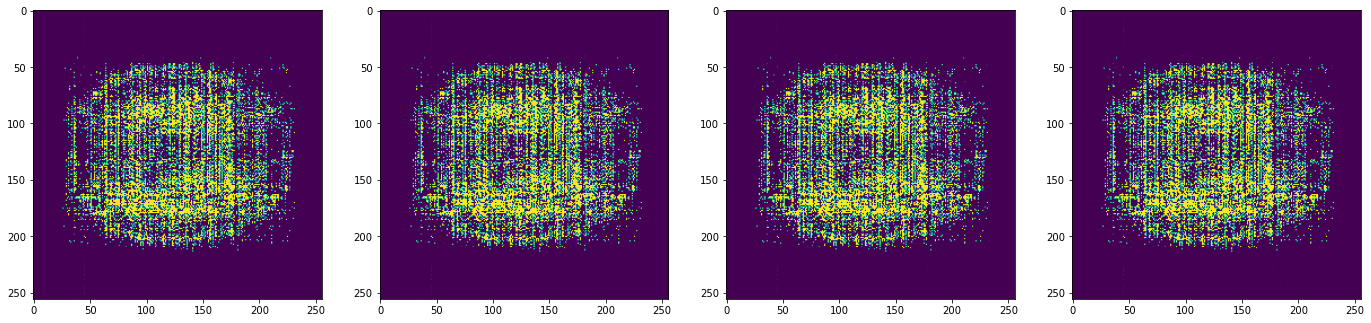

In [16]:
fig = plt.figure(figsize=(30,10))
nplot = 5
for count in range(1,5):
    ax = fig.add_subplot(1,5,count)
    ax.imshow(images[count-1])
plt.show()